# Importing the needed Libraries & Directories

Importing the required libraries and directories are important to avoid errors for it also allows the codes to work perfectly.

In [1]:
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
import torch
from torch.nn import Sequential
from torch.nn import Conv2d, MaxPool2d, BatchNorm2d
from sklearn.model_selection import train_test_split
directory = "./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("./face-mask-detection-dataset/train.csv")
df_test = pd.read_csv("./face-mask-detection-dataset/submission.csv")

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)

cuda


# Importing SSD pretrained weights (Caffe Face Detector Model)

In [3]:
cvNet = cv2.dnn.readNetFromCaffe('./caffe-face-detector-opencv-pretrained-model/architecture.txt','./caffe-face-detector-opencv-pretrained-model/weights.caffemodel')

# Functions to be used

Retrieves Json

In [4]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

Adjusts gamma to make images more bright

In [5]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

# Pre-processing the Data

In [6]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '2310.png',
 'NumOfAnno': 3,
 'Annotations': [{'isProtected': False,
   'ID': 81768340414106304,
   'BoundingBox': [213, 169, 325, 299],
   'classname': 'face_other_covering',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 613664631614999424,
   'BoundingBox': [171, 168, 346, 299],
   'classname': 'hijab_niqab',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 166231871773593440,
   'BoundingBox': [435, 183, 470, 223],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}]}

In [7]:

df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [8]:
print(df["classname"].unique())

['face_with_mask' 'mask_colorful' 'face_no_mask'
 'face_with_mask_incorrect' 'mask_surgical' 'face_other_covering'
 'scarf_bandana' 'eyeglasses' 'helmet' 'face_shield' 'sunglasses' 'hood'
 'hat' 'goggles' 'hair_net' 'hijab_niqab' 'other' 'gas_mask'
 'balaclava_ski_mask' 'turban']


In [9]:
len(df)

15412

In [10]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)  



In [17]:

import numpy

print(len(data))

with numpy.printoptions(threshold=numpy.inf):
    print(numpy.array(data[0][0]))


5749
[[[ 80  98  99]
  [ 80  98  99]
  [ 80  98  99]
  [ 80  98  99]
  [ 80  98  99]
  [ 82  97  99]
  [ 82  97  99]
  [ 82  97  99]
  [ 83  98 100]
  [ 83  98 101]
  [ 82  97 100]
  [ 83  96 101]
  [ 84  96 102]
  [ 83  95 101]
  [ 83  95 101]
  [ 83  95 101]
  [ 82  94 100]
  [ 82  94 100]
  [ 81  93  99]
  [ 80  93  99]
  [ 79  93  99]
  [ 78  93  98]
  [ 76  94  97]
  [ 75  93  96]
  [ 73  92  96]
  [ 73  92  95]
  [ 72  91  94]
  [ 72  91  94]
  [ 73  91  94]
  [ 73  90  93]
  [ 72  89  92]
  [ 71  88  91]
  [ 69  87  90]
  [ 68  85  88]
  [ 68  84  87]
  [ 67  82  85]
  [ 67  82  85]
  [ 67  82  85]
  [ 67  82  85]
  [ 67  82  84]
  [ 66  81  84]
  [ 66  79  83]
  [ 65  78  82]
  [ 64  76  80]
  [ 63  75  79]
  [ 61  73  77]
  [ 60  72  76]
  [ 59  72  76]
  [ 58  72  78]
  [ 58  72  78]
  [ 58  72  78]
  [ 58  72  78]
  [ 58  72  78]
  [ 58  72  78]
  [ 58  72  78]
  [ 58  72  78]
  [ 58  72  78]
  [ 58  72  78]
  [ 58  72  78]
  [ 58  72  78]
  [ 58  72  78]
  [ 58  72  78]
  [

<AxesSubplot:ylabel='count'>

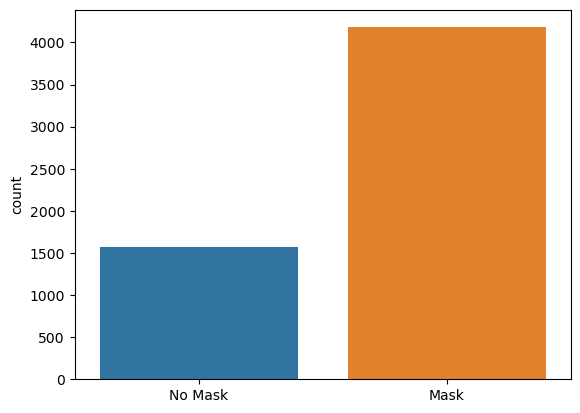

In [18]:
p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")

sns.countplot(x=p)

The lines of code below is used for getting the shape of the features in the face mask data.

In [19]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

print(type(Y[0]))


<class 'int'>


In [20]:
X[0].shape

(124, 124, 3)

The lines of code below is used for getting the labels in the face mask data.

In [21]:
X = np.array(X)/255.0
Y = np.array(Y)

In [22]:
np.unique(Y)

array([0, 1])

In [23]:
Y.shape

(5749,)

# Understanding the Model's Architecture and Training Process

The project's model architecture is only a rough abstraction. To start the training process we have to set the model to sequential first, after that we can start adding the needed attributes to the model.

In [24]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.maxpool = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(460800, 50)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.float()
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = nn.ReLU()(self.conv3(x))
        x = self.maxpool(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.dropout2(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x.type(torch.float)

model = Model()



print(model.conv1.weight.shape)
print(model.conv2.weight.shape)
print(model.conv3.weight.shape)
print(model.fc1.weight.shape)
print(model.fc2.weight.shape)




torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([50, 460800])
torch.Size([1, 50])


The line code below summarizes the model

In [38]:

model.to(device) 

AttributeError: type object 'Model' has no attribute 'summary'

The line code below is for compiling the model by setting the loss to binary cross entropy, the optimizer to adam, and lastly, the metrics to accuracy.

In [26]:
from livelossplot import PlotLosses


def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer,epochs):
    liveloss = PlotLosses()
    for epoch in range(epochs):
        logs = {}
        model.train() 
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in train_dl: 
            inputs = inputs.to(device)
            labels = labels.type(torch.float)
            labels = labels.to(device)
            outputs = model(inputs)
            outputs = outputs.reshape(-1)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
            
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(device)
            labels = labels.type(torch.float)
            labels = labels.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            outputs = outputs.reshape(-1)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()
        liveloss.update(logs)
        liveloss.send()
    torch.save(model,h5_file)

Next, to get the xtrain, xval, ytrain, and yval, we have to use the train_test_split.

In [31]:

from sklearn.model_selection import train_test_split


xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=42)



tensor1 = torch.from_numpy(np.array(xtrain))
tensor2 =  torch.from_numpy(np.array(xtest))

tensor1 = tensor1.reshape(-1,3,124,124)
tensor2 = tensor2.reshape(-1,3,124,124)


train = torch.utils.data.TensorDataset( tensor1, torch.tensor(ytrain))
test = torch.utils.data.TensorDataset(tensor2, torch.tensor(ytest))

print(tensor1.shape)
print(tensor2.shape)



train_dl = DataLoader(train, batch_size=32, shuffle=True)
test_dl = DataLoader(test, batch_size=32, shuffle=True)




torch.Size([4599, 3, 124, 124])
torch.Size([1150, 3, 124, 124])


In [32]:

i, (inputs, targets) = next(enumerate(train_dl))

print(inputs.shape)
print(targets.shape)


torch.Size([32, 3, 124, 124])
torch.Size([32])


In [33]:
import time
from torch.nn import BCELoss
from torch.optim import Adam

EPOCHS = 15
LEARNING_RATE = 0.001
criterion = BCELoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel.pth', train_dl, test_dl, model, criterion, optimizer,EPOCHS)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

KeyboardInterrupt: 